<a href="https://colab.research.google.com/github/Shashank-Holla/CNN_for_CIFAR10/blob/master/S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Tracking the changes
=====================
1. C1C2C3C4-0. 3 convolution in each convolution layers. 1.9M parameters. Train/Test accuracy- 82%/77%
2. C1C2C3C4-0. 2 convolution in each convolution layers. 1.2M parameters. Train/Test accuracy- 82%/76%
3. C1C2C3C4-0. Removed 2nd 256 channel convolution 585K parameters. Train/Test accuracy- 82%/75%
4. Seeing overfitting. Realized dropout was only 0.01. Bumped it to 0.1. No overfitting now. Train/test accuracy - 75%/73%.
5. Replaced normal conv2d with 256 channels with 256 depthwise seperable convolution. Train/Test accuracy - 75%/72%.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms


SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
import torch
import torchvision
def transform():
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)

  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  return trainloader, testloader, classes


Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



 ship  ship  bird   car


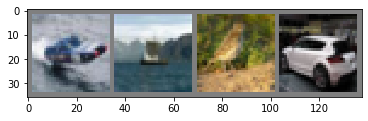

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

dropout_value = 0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Image size = 32. RF = 1
        #Convolution Layer-1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), #Output size- 32. RF=3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), #Output size- 32. RF=5
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) 

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 RF = 6 Jout = 2

        #Convolution Layer-2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), #Output size- 16. RF=10
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), #Output size- 16. RF=14
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        self.dilationblock1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=2, dilation=2, bias=False), #Output size- 16. RF=22
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) 

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 RF = 24 Jout = 4

        #Convolution Layer-3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), #Output size- 8. RF=32
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), #Output size- 8. RF=40
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        )

        self.pool3 = nn.MaxPool2d(2, 2) # output_size = 4 RF = 44 Jout = 8

        #Convolution Layer-4 294K parameters --> 32K
        #Depthwise Seperable Convolution
        self.DepthwiseSepConv = nn.Sequential(
            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False), 
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            # nn.Dropout(dropout_value)
            
            #Depthwise Convolution #Output size- 4. RF=60
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, groups = 128, bias=False),
            #Pointwise Convolution
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, 1), bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value)
        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        #Convolution Block-5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.dilationblock1(x)
        x = self.pool2(x)
        x = self.convblock3(x)
        x = self.pool3(x)
        x = self.DepthwiseSepConv(x)
        x = self.gap(x)
        x = self.convblock5(x)
        #print("Dimension of x",x.shape)
        x = x.view(-1, 10)
        return x


net = Net().to(device)
print(next(net.parameters()).is_cuda)

cuda
True


In [0]:
from torchsummary import summary

summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,432
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [0]:
#Training the model.
def train(net, device, trainloader, optimizer, criterion):
    net.train()  
    running_loss = 0.0
    epoch_train_loss = 0.0
    epoch_train_accuracy = 0
    correct = 0
    processed = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs. Data is not on cuda. Move it. Number of images, labels per iteration = batch size in transform
        inputs, labels = data
              
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() 

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) #Loss calculation is on cuda
        loss.backward()
        optimizer.step()

        #Accuracy calculation
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        processed += len(inputs)
        

        # print statistics
        running_loss += loss.item()
        epoch_train_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # print("Number of correct",correct,"\nTotal:",processed)    
    epoch_train_accuracy=(100*correct/processed)
    # print("Accuracy=",epoch_train_accuracy)
    epoch_train_loss /= i
    # print("Total loss for epoch: ",i, "is", epoch_train_loss)

    # print('Finished Training')
    
    return epoch_train_accuracy, epoch_train_loss

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


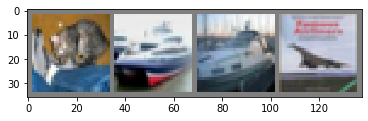

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
images = images.to(device)
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    car plane truck truck


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
# Test model
def test(net, device, testloader, criterion): 
  correct = 0
  total = 0
  epoch_test_loss = 0.0
  epoch_test_accuracy = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = net(images)

          epoch_test_loss += criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          epoch_test_accuracy = (100 * correct / total)
  epoch_test_loss /= len(testloader)
  # print("Test loss=",epoch_test_loss)
  # print('Accuracy of the network on the 10000 test images: %d %%' %epoch_test_accuracy)
  return epoch_test_accuracy, epoch_test_loss.cpu().numpy()

This is to call the test and train modules.

In [0]:
def train_test_metrics_graph(train_accuracy, train_loss, test_accuracy, test_loss):
  %matplotlib inline
  fig, axs = plt.subplots(1,2,figsize=(15,10))
  axs[0].set_title("Accuracy")
  axs[0].plot(train_accuracy, label = "train_accuracy")
  axs[0].plot(test_accuracy, label = "test accuracy")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="best")

  axs[1].set_title("Loss")
  axs[1].plot(train_loss, label = "train loss")
  axs[1].plot(test_loss, label = "test loss")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Loss")
  axs[1].legend(loc="best")

In [0]:
import torch.optim as optim
EPOCHS =10
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

for epoch in range(EPOCHS):
  print("epoch:", epoch)
  train_accuracy_delta, train_loss_delta = train(net, device, trainloader, optimizer,criterion)
  test_accuracy_delta, test_loss_delta = test(net, device, testloader,criterion)
  train_accuracy.append(train_accuracy_delta)
  train_loss.append(train_loss_delta)
  test_accuracy.append(test_accuracy_delta)
  test_loss.append(test_loss_delta)


epoch: 0
[1,  2000] loss: 1.888
[1,  4000] loss: 1.656
[1,  6000] loss: 1.534
[1,  8000] loss: 1.427
[1, 10000] loss: 1.374
[1, 12000] loss: 1.312
epoch: 1
[2,  2000] loss: 1.256
[2,  4000] loss: 1.205
[2,  6000] loss: 1.151
[2,  8000] loss: 1.161
[2, 10000] loss: 1.102
[2, 12000] loss: 1.084
epoch: 2
[3,  2000] loss: 1.035
[3,  4000] loss: 1.015
[3,  6000] loss: 1.015
[3,  8000] loss: 0.995
[3, 10000] loss: 0.985
[3, 12000] loss: 0.980
epoch: 3
[4,  2000] loss: 0.939
[4,  4000] loss: 0.947
[4,  6000] loss: 0.926
[4,  8000] loss: 0.908
[4, 10000] loss: 0.907
[4, 12000] loss: 0.899
epoch: 4
[5,  2000] loss: 0.854
[5,  4000] loss: 0.854
[5,  6000] loss: 0.862
[5,  8000] loss: 0.843
[5, 10000] loss: 0.853
[5, 12000] loss: 0.842
epoch: 5
[6,  2000] loss: 0.830
[6,  4000] loss: 0.807
[6,  6000] loss: 0.809
[6,  8000] loss: 0.801
[6, 10000] loss: 0.801
[6, 12000] loss: 0.831
epoch: 6
[7,  2000] loss: 0.748
[7,  4000] loss: 0.770
[7,  6000] loss: 0.779
[7,  8000] loss: 0.764
[7, 10000] loss: 

[46.13, 61.01, 66.632, 69.724, 72.208, 73.594, 74.852, 76.09, 76.788, 77.788]
[55.83, 64.73, 67.68, 69.85, 71.07, 72.65, 73.01, 73.96, 75.4, 75.07]
[1.5207038654647966, 1.1561938570407746, 1.0020633858054606, 0.9188085280806458, 0.8489144098468757, 0.8110311741313512, 0.7660452183847171, 0.7392366501376842, 0.7074851338549016, 0.6818603500026409]
[array(1.2817028, dtype=float32), array(1.0667663, dtype=float32), array(0.9770525, dtype=float32), array(0.9168547, dtype=float32), array(0.8873915, dtype=float32), array(0.832963, dtype=float32), array(0.8272867, dtype=float32), array(0.79676557, dtype=float32), array(0.76082855, dtype=float32), array(0.7734726, dtype=float32)]


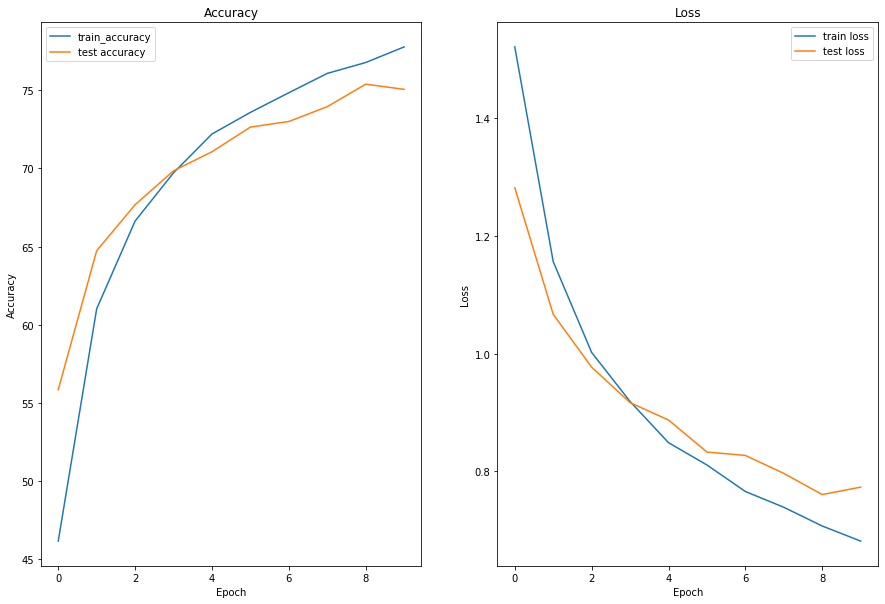

In [0]:
print(train_accuracy)
print(test_accuracy)

print(train_loss)
print(test_loss)
train_test_metrics_graph(train_accuracy, train_loss, test_accuracy, test_loss)

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 78 %
Accuracy of   car : 89 %
Accuracy of  bird : 64 %
Accuracy of   cat : 55 %
Accuracy of  deer : 72 %
Accuracy of   dog : 65 %
Accuracy of  frog : 79 %
Accuracy of horse : 78 %
Accuracy of  ship : 84 %
Accuracy of truck : 84 %


To chart accuracy and Loss of test and train.